In [1]:
# Run in python console
import nltk

### 预处理

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords

In [4]:
df = pd.read_excel("C:/Users/onrik\\report\\0203_LDA\\SBS 가공.xlsx")
df.columns = ['title','date','content']
df.head()

,title,date,content
0,"<strong class=""psil_tit"">신변보호 여성 가족 살해 이석준 기소…...",2021.12.31,신변보호를 받던 여성의 집에 찾아가 가족을 살해한 이석준이 재판에 넘겨졌습니다. ...
1,"<strong class=""psil_tit"">환자 20만 명 정보 제약사에 유출한...",2021.12.23,환자들의 개인 정보를 제약사에 유출한 주요 대학병원 전공의 등이 검찰에 송치됐습니...
2,"<strong class=""psil_tit"">문 대통령 ""EU <font styl...",2021.12.17,"문재인 대통령은 유럽연합, EU가 한국의 개인 정보보호 체계가 EU의 관련 법규 ..."
3,"<strong class=""psil_tit"">'신변보호' 전 여친 가족 살해 이석준...",2021.12.17,서울 송파경찰서는 오늘(17일) 한때 교제했던 여성의 집을 찾아가 가족을 살해한 이...
4,"<strong class=""psil_tit"">""50만 원에 주소 넘겨"" 그 뒤 가족...",2021.12.16,<앵커> 신변보호를 받던 여성의 가족을 숨지게 한 이석준에게 피해자 집 주소를 알...


In [5]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

df['content가공2'] = ''
for i in range(len(df)):
    df.at[i,'content가공2'] = ' '.join(x for x in data_words[i])
df

,title,date,content,content가공2
0,"<strong class=""psil_tit"">신변보호 여성 가족 살해 이석준 기소…...",2021.12.31,신변보호를 받던 여성의 집에 찾아가 가족을 살해한 이석준이 재판에 넘겨졌습니다. ...,신변보호를 받던 여성의 집에 찾아가 가족을 살해한 이석준이 재판에 넘겨졌습니다 서울...
1,"<strong class=""psil_tit"">환자 20만 명 정보 제약사에 유출한...",2021.12.23,환자들의 개인 정보를 제약사에 유출한 주요 대학병원 전공의 등이 검찰에 송치됐습니...,환자들의 개인 정보를 제약사에 유출한 주요 대학병원 전공의 등이 검찰에 송치됐습니다...
2,"<strong class=""psil_tit"">문 대통령 ""EU <font styl...",2021.12.17,"문재인 대통령은 유럽연합, EU가 한국의 개인 정보보호 체계가 EU의 관련 법규 ...",문재인 대통령은 유럽연합 eu가 한국의 개인 정보보호 체계가 eu의 관련 법규 수준...
3,"<strong class=""psil_tit"">'신변보호' 전 여친 가족 살해 이석준...",2021.12.17,서울 송파경찰서는 오늘(17일) 한때 교제했던 여성의 집을 찾아가 가족을 살해한 이...,서울 송파경찰서는 오늘 한때 교제했던 여성의 집을 찾아가 가족을 살해한 이석준 서울...
4,"<strong class=""psil_tit"">""50만 원에 주소 넘겨"" 그 뒤 가족...",2021.12.16,<앵커> 신변보호를 받던 여성의 가족을 숨지게 한 이석준에게 피해자 집 주소를 알...,앵커 신변보호를 받던 여성의 가족을 숨지게 이석준에게 피해자 주소를 알려준 흥신소 ...
...,...,...,...,...
124,"<strong class=""psil_tit"">""주진모 카톡도 내가 유출""…조주빈 거...",2020.03.27,미성년자를 포함한 여성의 성착취 영상을 제작·배포한 혐의를 받는 n번방 '박사' 조...,미성년자를 포함한 여성의 성착취 영상을 제작 배포한 혐의를 받는 n번방 박사 조주빈...
125,"<strong class=""psil_tit"">텔레그램서 미성년자 '노예' 지칭하며 ...",2020.03.20,인터넷 메신저 텔레그램 상에서 미성년자 등의 성 착취물을 제작·유포해 억대 수익을 ...,인터넷 메신저 텔레그램 상에서 미성년자 등의 착취물을 제작 유포해 억대 수익을 얻은...
126,"<strong class=""psil_tit"">검찰 관리 코로나19 관련 사건 198...",2020.03.09,검찰이 코로나19와 관련해 지휘하거나 수사 중인 사건이 200건에 육박하는 것으로 ...,검찰이 코로나 관련해 지휘하거나 수사 중인 사건이 건에 육박하는 것으로 나타났습니다...
127,"<strong class=""psil_tit"">불법 온상 '다크웹' 탓에…전 세계 카...",2020.02.18,지난 2018년 전 세계 카드 사기 규모가 278억 5천만 달러(약 33조 원)에 ...,지난 세계 카드 사기 규모가 천만 달러 달한 것으로 추정됐습니다 한국은행은 주요국의...


In [6]:
from konlpy.tag import Okt
okt = Okt()
cols = ['content가공2']
for i in range(len(df)):
    for col in cols:
        content_all = df.loc[i,col]
        morphs_txt = okt.pos(content_all,stem=True)
        df.at[i,col] = morphs_txt

resultdf = df
resultdf

,title,date,content,content가공2
0,"<strong class=""psil_tit"">신변보호 여성 가족 살해 이석준 기소…...",2021.12.31,신변보호를 받던 여성의 집에 찾아가 가족을 살해한 이석준이 재판에 넘겨졌습니다. ...,"[(신변, Noun), (보호, Noun), (를, Josa), (받다, Verb)..."
1,"<strong class=""psil_tit"">환자 20만 명 정보 제약사에 유출한...",2021.12.23,환자들의 개인 정보를 제약사에 유출한 주요 대학병원 전공의 등이 검찰에 송치됐습니...,"[(환자, Noun), (들, Suffix), (의, Josa), (개인, Noun..."
2,"<strong class=""psil_tit"">문 대통령 ""EU <font styl...",2021.12.17,"문재인 대통령은 유럽연합, EU가 한국의 개인 정보보호 체계가 EU의 관련 법규 ...","[(문재인, Noun), (대통령, Noun), (은, Josa), (유럽연합, N..."
3,"<strong class=""psil_tit"">'신변보호' 전 여친 가족 살해 이석준...",2021.12.17,서울 송파경찰서는 오늘(17일) 한때 교제했던 여성의 집을 찾아가 가족을 살해한 이...,"[(서울, Noun), (송파, Noun), (경찰서, Noun), (는, Josa..."
4,"<strong class=""psil_tit"">""50만 원에 주소 넘겨"" 그 뒤 가족...",2021.12.16,<앵커> 신변보호를 받던 여성의 가족을 숨지게 한 이석준에게 피해자 집 주소를 알...,"[(앵커, Noun), (신변, Noun), (보호, Noun), (를, Josa)..."
...,...,...,...,...
124,"<strong class=""psil_tit"">""주진모 카톡도 내가 유출""…조주빈 거...",2020.03.27,미성년자를 포함한 여성의 성착취 영상을 제작·배포한 혐의를 받는 n번방 '박사' 조...,"[(미성년, Noun), (자, Suffix), (를, Josa), (포함, Nou..."
125,"<strong class=""psil_tit"">텔레그램서 미성년자 '노예' 지칭하며 ...",2020.03.20,인터넷 메신저 텔레그램 상에서 미성년자 등의 성 착취물을 제작·유포해 억대 수익을 ...,"[(인터넷, Noun), (메신저, Noun), (텔레, Noun), (그램, No..."
126,"<strong class=""psil_tit"">검찰 관리 코로나19 관련 사건 198...",2020.03.09,검찰이 코로나19와 관련해 지휘하거나 수사 중인 사건이 200건에 육박하는 것으로 ...,"[(검찰, Noun), (이, Josa), (코로나, Noun), (관련, Noun..."
127,"<strong class=""psil_tit"">불법 온상 '다크웹' 탓에…전 세계 카...",2020.02.18,지난 2018년 전 세계 카드 사기 규모가 278억 5천만 달러(약 33조 원)에 ...,"[(지난, Noun), (세계, Noun), (카드, Noun), (사기, Noun..."


In [7]:
for i in range(len(resultdf)):
    for col in cols:
        lls = []
        if len(resultdf.loc[i,col]) == 0:
            pass
        else:
            for j in range(len(resultdf.loc[i,col])):
                if resultdf.loc[i,col][j][1] in ['Noun','Hashtag','Adjective']:
                    if resultdf.loc[i,col][j][1] == 'Hashtag':
                        lls.append((resultdf.loc[i,col][j][0].split('#')[-1],resultdf.loc[i,col][j][1]))
                    else:
                        lls.append(resultdf.loc[i,col][j])
            resultdf.at[i,col] = lls
resultdf

,title,date,content,content가공2
0,"<strong class=""psil_tit"">신변보호 여성 가족 살해 이석준 기소…...",2021.12.31,신변보호를 받던 여성의 집에 찾아가 가족을 살해한 이석준이 재판에 넘겨졌습니다. ...,"[(신변, Noun), (보호, Noun), (여성, Noun), (집, Noun)..."
1,"<strong class=""psil_tit"">환자 20만 명 정보 제약사에 유출한...",2021.12.23,환자들의 개인 정보를 제약사에 유출한 주요 대학병원 전공의 등이 검찰에 송치됐습니...,"[(환자, Noun), (개인, Noun), (정보, Noun), (약사, Noun..."
2,"<strong class=""psil_tit"">문 대통령 ""EU <font styl...",2021.12.17,"문재인 대통령은 유럽연합, EU가 한국의 개인 정보보호 체계가 EU의 관련 법규 ...","[(문재인, Noun), (대통령, Noun), (유럽연합, Noun), (한국, ..."
3,"<strong class=""psil_tit"">'신변보호' 전 여친 가족 살해 이석준...",2021.12.17,서울 송파경찰서는 오늘(17일) 한때 교제했던 여성의 집을 찾아가 가족을 살해한 이...,"[(서울, Noun), (송파, Noun), (경찰서, Noun), (오늘, Nou..."
4,"<strong class=""psil_tit"">""50만 원에 주소 넘겨"" 그 뒤 가족...",2021.12.16,<앵커> 신변보호를 받던 여성의 가족을 숨지게 한 이석준에게 피해자 집 주소를 알...,"[(앵커, Noun), (신변, Noun), (보호, Noun), (여성, Noun..."
...,...,...,...,...
124,"<strong class=""psil_tit"">""주진모 카톡도 내가 유출""…조주빈 거...",2020.03.27,미성년자를 포함한 여성의 성착취 영상을 제작·배포한 혐의를 받는 n번방 '박사' 조...,"[(미성년, Noun), (포함, Noun), (여성, Noun), (착취, Nou..."
125,"<strong class=""psil_tit"">텔레그램서 미성년자 '노예' 지칭하며 ...",2020.03.20,인터넷 메신저 텔레그램 상에서 미성년자 등의 성 착취물을 제작·유포해 억대 수익을 ...,"[(인터넷, Noun), (메신저, Noun), (텔레, Noun), (그램, No..."
126,"<strong class=""psil_tit"">검찰 관리 코로나19 관련 사건 198...",2020.03.09,검찰이 코로나19와 관련해 지휘하거나 수사 중인 사건이 200건에 육박하는 것으로 ...,"[(검찰, Noun), (코로나, Noun), (관련, Noun), (휘하, Nou..."
127,"<strong class=""psil_tit"">불법 온상 '다크웹' 탓에…전 세계 카...",2020.02.18,지난 2018년 전 세계 카드 사기 규모가 278억 5천만 달러(약 33조 원)에 ...,"[(지난, Noun), (세계, Noun), (카드, Noun), (사기, Noun..."


In [8]:
k_stopword = pd.read_csv("korean_stopword_0317.csv")
k_stopword = list(k_stopword['불용어'])
for i in range(len(resultdf)):
    for col in cols:
        newlst = []
        for word in resultdf.loc[i,col]:
            if word[0] not in k_stopword:
                newlst.append(word)
        resultdf.at[i,col] = newlst
ldadf = resultdf

In [9]:
for col in cols:
    resultdf[col + 'bigram'] = ''

for i in range(len(resultdf)):
    for col in cols:
        newlst = resultdf.loc[i,col]
        if len(newlst) == 0 or len(newlst) == 1:
            pass
        else:
            bigram = [newlst[0][0] + '_' + newlst[1][0]]
            if len(newlst) == 2:
                resultdf.at[i,col+'bigram'] = bigram
            else:
                for j in range(2,len(newlst)):
                    biword = newlst[j-1][0] + '_' + newlst[j][0]
                    triword = newlst[j-2][0] + '_' + newlst[j-1][0] + '_' + newlst[j][0]
                    bigram.append(biword)
                resultdf.at[i,col+'bigram'] = bigram
resultdf

,title,date,content,content가공2,content가공2bigram
0,"<strong class=""psil_tit"">신변보호 여성 가족 살해 이석준 기소…...",2021.12.31,신변보호를 받던 여성의 집에 찾아가 가족을 살해한 이석준이 재판에 넘겨졌습니다. ...,"[(신변, Noun), (보호, Noun), (여성, Noun), (가족, Noun...","[신변_보호, 보호_여성, 여성_가족, 가족_살해, 살해_이석준, 이석준_재판, 재..."
1,"<strong class=""psil_tit"">환자 20만 명 정보 제약사에 유출한...",2021.12.23,환자들의 개인 정보를 제약사에 유출한 주요 대학병원 전공의 등이 검찰에 송치됐습니...,"[(환자, Noun), (개인, Noun), (정보, Noun), (약사, Noun...","[환자_개인, 개인_정보, 정보_약사, 약사_유출, 유출_주요, 주요_대학병원, 대..."
2,"<strong class=""psil_tit"">문 대통령 ""EU <font styl...",2021.12.17,"문재인 대통령은 유럽연합, EU가 한국의 개인 정보보호 체계가 EU의 관련 법규 ...","[(문재인, Noun), (대통령, Noun), (유럽연합, Noun), (한국, ...","[문재인_대통령, 대통령_유럽연합, 유럽연합_한국, 한국_개인, 개인_정보보호, 정..."
3,"<strong class=""psil_tit"">'신변보호' 전 여친 가족 살해 이석준...",2021.12.17,서울 송파경찰서는 오늘(17일) 한때 교제했던 여성의 집을 찾아가 가족을 살해한 이...,"[(서울, Noun), (송파, Noun), (경찰서, Noun), (교제, Nou...","[서울_송파, 송파_경찰서, 경찰서_교제, 교제_여성, 여성_가족, 가족_살해, 살..."
4,"<strong class=""psil_tit"">""50만 원에 주소 넘겨"" 그 뒤 가족...",2021.12.16,<앵커> 신변보호를 받던 여성의 가족을 숨지게 한 이석준에게 피해자 집 주소를 알...,"[(앵커, Noun), (신변, Noun), (보호, Noun), (여성, Noun...","[앵커_신변, 신변_보호, 보호_여성, 여성_가족, 가족_이석준, 이석준_피해자, ..."
...,...,...,...,...,...
124,"<strong class=""psil_tit"">""주진모 카톡도 내가 유출""…조주빈 거...",2020.03.27,미성년자를 포함한 여성의 성착취 영상을 제작·배포한 혐의를 받는 n번방 '박사' 조...,"[(미성년, Noun), (포함, Noun), (여성, Noun), (착취, Nou...","[미성년_포함, 포함_여성, 여성_착취, 착취_영상, 영상_제작, 제작_배포, 배포..."
125,"<strong class=""psil_tit"">텔레그램서 미성년자 '노예' 지칭하며 ...",2020.03.20,인터넷 메신저 텔레그램 상에서 미성년자 등의 성 착취물을 제작·유포해 억대 수익을 ...,"[(인터넷, Noun), (메신저, Noun), (텔레, Noun), (그램, No...","[인터넷_메신저, 메신저_텔레, 텔레_그램, 그램_상, 상_미성년, 미성년_착취, ..."
126,"<strong class=""psil_tit"">검찰 관리 코로나19 관련 사건 198...",2020.03.09,검찰이 코로나19와 관련해 지휘하거나 수사 중인 사건이 200건에 육박하는 것으로 ...,"[(검찰, Noun), (코로나, Noun), (휘하, Noun), (거나, Nou...","[검찰_코로나, 코로나_휘하, 휘하_거나, 거나_수사, 수사_중인, 중인_사건, 사..."
127,"<strong class=""psil_tit"">불법 온상 '다크웹' 탓에…전 세계 카...",2020.02.18,지난 2018년 전 세계 카드 사기 규모가 278억 5천만 달러(약 33조 원)에 ...,"[(세계, Noun), (카드, Noun), (사기, Noun), (규모, Noun...","[세계_카드, 카드_사기, 사기_규모, 규모_달러, 달러_달, 달_추정, 추정_한국..."


In [10]:
gramlst = []
gramcol = ['content가공2', 'content가공2bigram']

for gram in gramcol:

    contents_all = []
    for i in range(len(resultdf)):
        contents_all += resultdf.loc[i,gram]
    gramlst.append({'column':gram+'_all','data': contents_all})
gramdf = pd.DataFrame(gramlst)

from collections import Counter
contents_all = []
for i in range(1,len(gramdf)):
    contents_all += gramdf.loc[i,'data']

ngram_count = Counter(contents_all)
rank_ngram = ngram_count.most_common()
rank_ngram = dict(rank_ngram)
count_len = 10
ngram_dic = {}
for key,value in rank_ngram.items():
    if value > count_len:
        ngram_dic[key] = value
rank_ngram = ngram_dic

ngram_dic = {}
for key,value in rank_ngram.items():
    ngram_dic[key] = value
list(ngram_dic.keys())

['개인_정보',
 '개인정보보호법_위반',
 '위반_혐의',
 '박사_방',
 '사진_연합뉴스',
 '정보_수집',
 '정보_유출',
 '주민_센터',
 '경찰_수사',
 '혐의_적용',
 '개인_정보보호',
 '수사_정보',
 '무상_비밀',
 '비밀_누설',
 '정보_주체',
 '공수_처가',
 '정보_처리',
 '고위_공직자',
 '고발_사주',
 '정보_정책',
 '아동_청소년',
 '복무_요원',
 '불법_조회',
 '사주_의혹',
 '정보_제공',
 '기자_기자',
 '정보_불법',
 '혐의_기소',
 '텔레_그램',
 '법_위반',
 '인사_팀',
 '착취_물',
 '정책_관',
 '비서_관',
 '특감_반원',
 '국민_힘',
 '정정_순',
 '신상_공개',
 '카카오_톡',
 '식당_주인',
 '처_처',
 '문건_작성',
 '선거법_위반',
 '중앙_검',
 '명의_개인',
 '영상_취재',
 '대검_수사',
 '윤석열_검찰총장',
 '정보_도용',
 '이성윤_검사',
 '정보보호_위원회',
 '징계_사유',
 '직무_범위',
 '사건_건',
 '검찰_송치',
 '공직자_범죄수사',
 '범죄수사_처',
 '성남_시청',
 '순_의원',
 '충성_심',
 '진상_조사',
 '공직선거법_위반',
 '사건_수사',
 '수사_착수',
 '법무부_장관',
 '수사_의뢰',
 '차장_검사',
 '제공_혐의',
 '가명_처리',
 '경찰_관계자',
 '수사_중인',
 '지방_경찰청',
 '착취_영상']

In [11]:
ngram_word = ['개인_정보',
 '개인정보보호법_위반',
 '박사_방',
 '주민_센터',
 '경찰_수사',
 '개인_정보보호',
 '정보_주체',
 '정보_처리',
 '정보_정책',
 '복무_요원',
 '정보_제공',
 '텔레_그램',
 '인사_팀',
 '착취_물',
 '비서_관',
 '국민_힘',
 '신상_공개',
 '카카오_톡',
 '선거법_위반',
 '정보_도용',
 '정보보호_위원회',
 '범죄수사_처',
 '충성_심',
 '법무부_장관',
 '가명_처리',
 '지방_경찰청',
 '착취_영상']
ngram_word

['개인_정보',
 '개인정보보호법_위반',
 '박사_방',
 '주민_센터',
 '경찰_수사',
 '개인_정보보호',
 '정보_주체',
 '정보_처리',
 '정보_정책',
 '복무_요원',
 '정보_제공',
 '텔레_그램',
 '인사_팀',
 '착취_물',
 '비서_관',
 '국민_힘',
 '신상_공개',
 '카카오_톡',
 '선거법_위반',
 '정보_도용',
 '정보보호_위원회',
 '범죄수사_처',
 '충성_심',
 '법무부_장관',
 '가명_처리',
 '지방_경찰청',
 '착취_영상']

In [12]:
resultdf = resultdf[['content가공2']]
resultdf

,content가공2
0,"[(신변, Noun), (보호, Noun), (여성, Noun), (가족, Noun..."
1,"[(환자, Noun), (개인, Noun), (정보, Noun), (약사, Noun..."
2,"[(문재인, Noun), (대통령, Noun), (유럽연합, Noun), (한국, ..."
3,"[(서울, Noun), (송파, Noun), (경찰서, Noun), (교제, Nou..."
4,"[(앵커, Noun), (신변, Noun), (보호, Noun), (여성, Noun..."
...,...
124,"[(미성년, Noun), (포함, Noun), (여성, Noun), (착취, Nou..."
125,"[(인터넷, Noun), (메신저, Noun), (텔레, Noun), (그램, No..."
126,"[(검찰, Noun), (코로나, Noun), (휘하, Noun), (거나, Nou..."
127,"[(세계, Noun), (카드, Noun), (사기, Noun), (규모, Noun..."


In [13]:
nolst = []
def 가공(title):
    title_counts = []
    for i in range(len(title)):
        title_counts.append(title[i][0])
        if i >= 2:
            biword = title[i-1][0] + '_' + title[i][0]
            if biword in ngram_word:
                biword2 = title[i-1][0] + title[i][0]
                if biword == '국민_힘':
                    biword2 = '국민의힘'
                elif biword == '쿠팡_츠':
                    biword2 = '쿠팡이츠'
                elif biword == '중앙_검':
                    biword2 = '중앙검찰'
                title_counts.pop()
                title_counts.pop()
                title_counts.append(biword2)

    result_title = []
    for cc in title_counts:
        if len(cc) != 1 or cc in nolst:
            result_title.append(cc)
    return result_title

reco = resultdf.columns
for recol in reco:
    resultdf[recol] = resultdf[recol].apply(lambda x:가공(x))
resultdf

<ipython-input-13-e60cb8612f84>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultdf[recol] = resultdf[recol].apply(lambda x:가공(x))


,content가공2
0,"[신변, 보호, 여성, 가족, 살해, 이석준, 재판, 동부, 강력범죄, 전담, 형사..."
1,"[환자, 개인정보, 약사, 유출, 주요, 대학병원, 전공, 검찰, 송치, 경찰청, ..."
2,"[문재인, 대통령, 유럽연합, 한국, 개인정보보호, 체계, 법규, 수준, 적정하다,..."
3,"[서울, 송파, 경찰서, 교제, 여성, 가족, 살해, 이석준, 동부, 구속, 송치,..."
4,"[앵커, 신변, 보호, 여성, 가족, 이석준, 피해자, 주소, 흥신소, 업자, 구속..."
...,...
124,"[미성년, 포함, 여성, 착취영상, 제작, 배포, 혐의, 번방, 박사, 주진모, 카..."
125,"[인터넷, 메신저, 텔레그램, 미성년, 착취물, 제작, 유포, 억대, 수익, 박사방..."
126,"[검찰, 코로나, 휘하, 거나, 수사, 중인, 사건, 육박, 대검찰청, 검찰, 관리..."
127,"[세계, 카드, 사기, 규모, 달러, 추정, 한국은행, 지급, 수단, 사기, 동향,..."


In [14]:
data_lemmatized = resultdf.content가공2.values.tolist()
data_lemmatized

[['신변',
  '보호',
  '여성',
  '가족',
  '살해',
  '이석준',
  '재판',
  '동부',
  '강력범죄',
  '전담',
  '형사',
  '특가법',
  '보복',
  '살인',
  '살인',
  '미수',
  '살인',
  '예비',
  '감금',
  '혐의',
  '적용',
  '이씨',
  '구속기소',
  '검찰',
  '경찰',
  '송치',
  '개인정보보호법위반',
  '혐의',
  '추가',
  '적용',
  '범행',
  '흥신소',
  '피해자',
  '거주지',
  '정보',
  '서울',
  '송파구',
  '잠실동',
  '여성',
  '흉기',
  '어머니',
  '살해',
  '남동생',
  '중상',
  '혐의',
  '범행',
  '나흘',
  '전인',
  '부모',
  '신고',
  '대구',
  '경찰서',
  '성폭행',
  '감금',
  '혐의',
  '조사',
  '앙심',
  '범행',
  '계획',
  '조사',
  '경찰서',
  '긴급',
  '체포',
  '요건',
  '이유',
  '이씨',
  '신병',
  '확보',
  '대구',
  '서울',
  '경찰',
  '신변',
  '보호',
  '요청',
  '스마트워치',
  '지급',
  '접근',
  '이씨',
  '인터넷',
  '발견',
  '흥신소',
  '주소지',
  '파악',
  '주거지',
  '인근',
  '가족',
  '동향',
  '살피',
  '철저하다',
  '범행',
  '계획',
  '가방',
  '여러',
  '흉기',
  '밧줄',
  '장갑',
  '밀가루',
  '발견',
  '범행',
  '당일',
  '이씨',
  '외출',
  '침입',
  '어머니',
  '전기충격기',
  '충격',
  '흉기',
  '살해',
  '남동생',
  '부위',
  '중상',
  '병원',
  '이송',
  '의식',
  '회복하다',
  '병원',
  '치료',
  '검찰',
  '거주지',
  '혐의',

### TF-IDF

In [15]:
### Term-Frequency
from collections import Counter
words = ''
for i in range(len(data_lemmatized)):
    t = ' '.join(data_lemmatized[i])
    words += t
words = words.split()
counts = Counter(words)
counts

Counter({'신변': 5,
         '보호': 36,
         '여성': 59,
         '가족': 26,
         '살해': 10,
         '이석준': 8,
         '재판': 85,
         '동부': 4,
         '강력범죄': 2,
         '전담': 5,
         '형사': 27,
         '특가법': 3,
         '보복': 8,
         '살인': 14,
         '미수': 8,
         '예비': 6,
         '감금': 5,
         '혐의': 228,
         '적용': 46,
         '이씨': 5,
         '구속기소': 7,
         '검찰': 142,
         '경찰': 152,
         '송치': 17,
         '개인정보보호법위반': 108,
         '추가': 26,
         '범행': 23,
         '흥신소': 14,
         '피해자': 84,
         '거주지': 4,
         '정보': 153,
         '서울': 59,
         '송파구': 5,
         '잠실동': 2,
         '흉기': 8,
         '어머니': 6,
         '남동생': 5,
         '중상': 3,
         '나흘': 5,
         '전인': 4,
         '부모': 7,
         '신고': 23,
         '대구': 7,
         '경찰서': 20,
         '성폭행': 6,
         '조사': 118,
         '앙심': 2,
         '계획': 16,
         '긴급': 6,
         '체포': 16,
         '요건': 3,
         '이유': 23,
         '신

In [16]:
vocab = sorted(counts, key=counts.get, reverse=True)
tf_df = []
for voca in vocab:
    tf_df.append({'word': voca, 'term frequency': counts[voca]})
tf_df = pd.DataFrame(tf_df)
tf_df.head(10)

,word,term frequency
0,혐의,228
1,수사,185
2,개인정보,178
3,정보,153
4,경찰,152
5,검찰,142
6,검사,123
7,의원,122
8,조사,118
9,사건,118


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
contents_tfidf = []
for i in range(len(data_lemmatized)):
    t = ' '.join(data_lemmatized[i])
    contents_tfidf.append(t)
vectorizer = TfidfVectorizer(stop_words='english', max_features= 100)
X = vectorizer.fit_transform(contents_tfidf)

# # TF-IDF 행렬의 크기 확인
# print('TF-IDF 행렬의 크기 :',X.shape)
tf_idfdict=  vectorizer.get_feature_names()
data_array = X.toarray()
data_tdidf = pd.DataFrame(data_array, columns=tf_idfdict)
data_tdidf


,감찰,개인,개인정보,개인정보보호법,개인정보보호법위반,검사,검찰,검토,결과,경찰,...,피의자,피해,피해자,학교,학생,한국,행위,혐의,환자,휴대전화
0,0.0,0.0,0.000000,0.000000,0.076799,0.0,0.217502,0.000000,0.000000,0.221833,...,0.000000,0.000000,0.146169,0.0,0.0,0.000000,0.000000,0.445400,0.000000,0.000000
1,0.0,0.0,0.121993,0.051209,0.032994,0.0,0.046721,0.000000,0.000000,0.047652,...,0.000000,0.000000,0.125593,0.0,0.0,0.000000,0.000000,0.038270,0.358153,0.000000
2,0.0,0.0,0.119452,0.150429,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.952785,0.000000,0.000000,0.000000,0.000000
3,0.0,0.0,0.000000,0.000000,0.052926,0.0,0.000000,0.000000,0.000000,0.611501,...,0.000000,0.000000,0.201463,0.0,0.0,0.000000,0.000000,0.245557,0.000000,0.000000
4,0.0,0.0,0.233590,0.000000,0.063177,0.0,0.089461,0.138112,0.000000,0.638699,...,0.000000,0.000000,0.120242,0.0,0.0,0.000000,0.000000,0.219839,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,0.0,0.0,0.000000,0.000000,0.065232,0.0,0.184742,0.000000,0.137871,0.282631,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.226989,0.000000,0.140181
125,0.0,0.0,0.030811,0.000000,0.025000,0.0,0.035401,0.054652,0.000000,0.505481,...,0.057745,0.093872,0.237906,0.0,0.0,0.000000,0.000000,0.057995,0.000000,0.000000
126,0.0,0.0,0.000000,0.000000,0.049097,0.0,0.417143,0.000000,0.000000,0.070908,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.399714,0.000000
127,0.0,0.0,0.056399,0.035512,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.042957,0.000000,0.0,0.0,0.000000,0.044792,0.000000,0.000000,0.000000


In [18]:
def getTFIDF(text_series):
    """Performs TF-IDF calculation on a matrix of words grouped into cells."""
    vectorizer = TfidfVectorizer()

    matrix = vectorizer.fit_transform(text_series).todense()

    matrix_df = pd.DataFrame(matrix, columns=vectorizer.get_feature_names())


    return matrix_df.sum(axis=0).sort_values(ascending=False)

# # Create Corpus for TD-IDF analysis 
text_df = pd.DataFrame()
text_df["text_clean"] = data_lemmatized # Use the data_lemmatized for text analysis
text_to_tfidf = [",".join(text) for text in text_df["text_clean"].values]

# Getting TD-IDF scores for words 
topwords = getTFIDF(text_to_tfidf)
topwords.to_excel("topwords.xlsx")
topwords_50 = topwords[:50]
topwords_50.to_excel("SBS_topwords_tf_idf_50.xlsx")

In [19]:
topwords

혐의      6.069119
의원      5.234980
개인정보    4.953044
수사      4.845014
경찰      4.636705
          ...   
일꾼      0.021980
발탁      0.021980
요체      0.021980
마저      0.021980
영향      0.021980
Length: 3528, dtype: float64

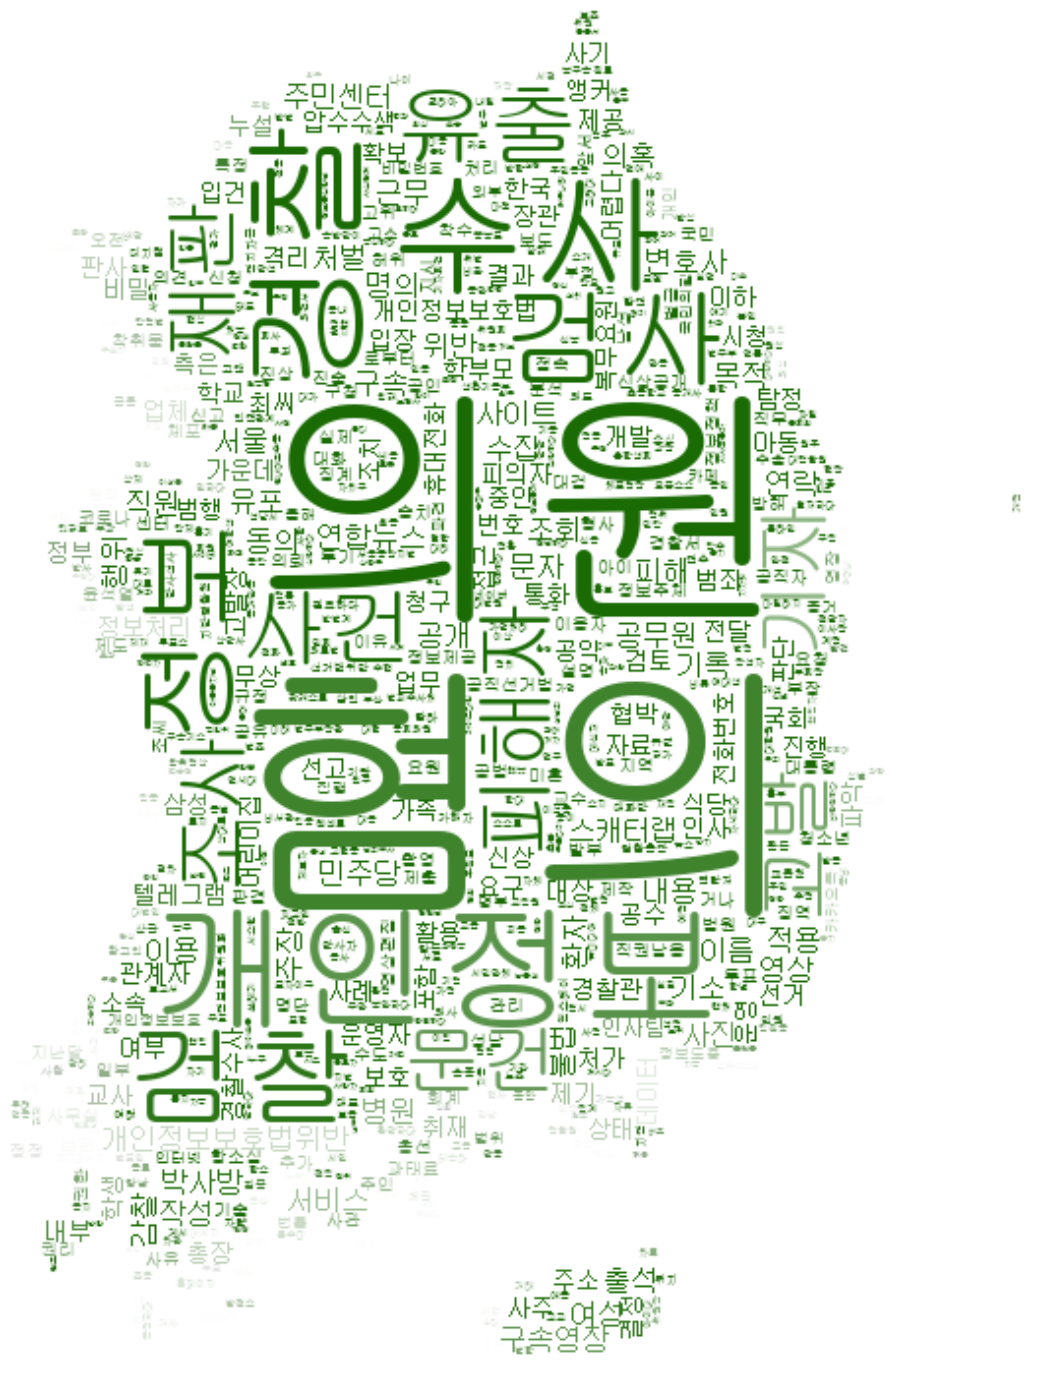

In [20]:
# Importing word cloud
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from PIL import Image

## Creating a masked wordcloud using TD-IDF
fig, ax = plt.subplots(figsize=(25,25))
custom_mask = np.array(Image.open("korea2.jpg"))
w = WordCloud(font_path='C:\\Windows\\Fonts\\gulim.ttc',
              background_color = 'white',
              width=800,height=600,
              mask = custom_mask,
              mode='RGBA',
              max_words=2000).fit_words(topwords)
image_colors = ImageColorGenerator(custom_mask)
w.recolor(color_func = image_colors)
plt.imshow(w, interpolation="bilinear")
plt.axis("off")
plt.show()
fig.savefig('SBS_TFIDF_Wordcloud.png', dpi=800)

### LDA

In [54]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 2), (3, 1), (4, 1), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 5), (25, 2), (26, 1), (27, 2), (28, 1), (29, 1), (30, 3), (31, 1), (32, 3), (33, 2), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 2), (44, 1), (45, 1), (46, 2), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 4), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 2), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 2), (70, 1), (71, 1), (72, 2), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 5), (85, 1), (86, 1), (87, 1), (88, 3), (89, 3)]]


In [55]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# mallet_path = 'mallet-2.0.8/bin/mallet'  # update this path
# mallet_path = 'path/to/mallet-2.0.8/bin/mallet' # update this path
import os
os.environ.update({'MALLET_HOME':r'C:/Users/onrik/Downloads/mallet-2.0.8/mallet-2.0.8/'})

mallet_path = 'C:/Users/onrik/Downloads/mallet-2.0.8/mallet-2.0.8/bin/mallet' # update this path


# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=8, id2word=id2word)

In [56]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()

[(0,
  [('정보', 0.046267496111975115),
   ('개인정보', 0.03654743390357698),
   ('수집', 0.029937791601866253),
   ('동의', 0.01827371695178849),
   ('행위', 0.01827371695178849),
   ('서비스', 0.01671850699844479),
   ('개인정보보호법', 0.015552099533437015),
   ('목적', 0.014774494556765163),
   ('결과', 0.014385692068429238),
   ('정보처리', 0.013608087091757388)]),
 (1,
  [('처벌', 0.021720243266724587),
   ('기자', 0.021720243266724587),
   ('앵커', 0.017810599478714162),
   ('연락', 0.015638575152041704),
   ('교사', 0.015204170286707211),
   ('병원', 0.014335360556038228),
   ('학생', 0.014335360556038228),
   ('경찰', 0.013466550825369244),
   ('개인정보', 0.013466550825369244),
   ('학교', 0.01259774109470026)]),
 (2,
  [('경찰', 0.03830313014827018),
   ('혐의', 0.03706754530477759),
   ('피해자', 0.027182866556836903),
   ('박사방', 0.018533772652388796),
   ('범죄', 0.015650741350906095),
   ('아동', 0.015238879736408566),
   ('파악', 0.014827018121911038),
   ('수사', 0.014827018121911038),
   ('사기', 0.014415156507413509),
   ('유포', 0.01235

In [57]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [58]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=30, step=2)

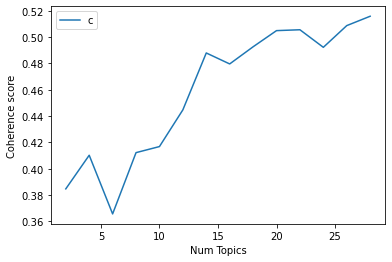

In [59]:
# Show graph
limit=30; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [60]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
model_list

Num Topics = 2  has Coherence Value of 0.3847
Num Topics = 4  has Coherence Value of 0.4102
Num Topics = 6  has Coherence Value of 0.3657
Num Topics = 8  has Coherence Value of 0.4122
Num Topics = 10  has Coherence Value of 0.4168
Num Topics = 12  has Coherence Value of 0.4447
Num Topics = 14  has Coherence Value of 0.4879
Num Topics = 16  has Coherence Value of 0.4795
Num Topics = 18  has Coherence Value of 0.4926
Num Topics = 20  has Coherence Value of 0.5048
Num Topics = 22  has Coherence Value of 0.5055
Num Topics = 24  has Coherence Value of 0.4922
Num Topics = 26  has Coherence Value of 0.5087
Num Topics = 28  has Coherence Value of 0.5158


In [67]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=20))

[(0,
  '0.046*"수사" + 0.022*"의혹" + 0.022*"검사" + 0.019*"문건" + 0.018*"고발" + 0.016*"의원" '
  '+ 0.014*"공무원" + 0.012*"개인정보보호법위반" + 0.012*"작성" + 0.012*"압수수색" + 0.012*"대상" '
  '+ 0.012*"진행" + 0.011*"기자" + 0.011*"전달" + 0.010*"총장" + 0.010*"소속" + '
  '0.010*"고발장" + 0.010*"비밀" + 0.009*"고위" + 0.009*"직원"'),
 (1,
  '0.058*"혐의" + 0.035*"경찰" + 0.018*"개인정보" + 0.017*"피해자" + 0.017*"박사방" + '
  '0.017*"불법" + 0.016*"서울" + 0.014*"아동" + 0.013*"명의" + 0.013*"근무" + 0.012*"구속" '
  '+ 0.012*"조회" + 0.012*"유포" + 0.011*"주민센터" + 0.011*"공익" + 0.010*"적용" + '
  '0.010*"구속영장" + 0.009*"파악" + 0.009*"검찰" + 0.009*"개인정보보호법위반"'),
 (2,
  '0.018*"조사" + 0.017*"사진" + 0.017*"조치" + 0.013*"한국" + 0.013*"요구" + 0.013*"이용" '
  '+ 0.012*"정부" + 0.011*"투기" + 0.011*"코로나" + 0.011*"스캐터랩" + 0.011*"관리" + '
  '0.011*"공유" + 0.010*"포함" + 0.010*"거래" + 0.010*"개발" + 0.009*"국민" + '
  '0.009*"데이터" + 0.009*"사례" + 0.008*"본인" + 0.007*"이용자"'),
 (3,
  '0.039*"정보" + 0.019*"탐정" + 0.017*"수집" + 0.017*"서비스" + 0.016*"사기" + '
  '0.016*"개인정보보호법" + 0.012*"주소" + 0.012*"

In [68]:
ldadf = []
for i in range(len(optimal_model.print_topics(num_words= 20))):
    topic = optimal_model.print_topics(num_words= 20)[i]
    topic_num = 'topic' + ' ' + str(i+1)
    for j in range(len(topic[1].split(" + "))):
        term = topic[1].split(" + ")[j].split("*")[1][1:-1]
        ldanum = topic[1].split(" + ")[j].split("*")[0]
        ldadf.append({"topic": topic_num, 'term':term, 'lda_num':ldanum})
ldadf = pd.DataFrame(ldadf)
print(len(ldadf), ldadf.term.nunique())
ldadf

160 141


,topic,term,lda_num
0,topic 1,수사,0.046
1,topic 1,의혹,0.022
2,topic 1,검사,0.022
3,topic 1,문건,0.019
4,topic 1,고발,0.018
...,...,...,...
155,topic 8,자료,0.010
156,topic 8,변호사,0.010
157,topic 8,위반,0.009
158,topic 8,변호인,0.009


In [69]:
ldadf.to_excel("SBS LDAdf_final2.xlsx", index=False)

In [70]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.5076,"혐의, 경찰, 개인정보, 피해자, 박사방, 불법, 서울, 아동, 명의, 근무",신변보호를 받던 여성의 집에 찾아가 가족을 살해한 이석준이 재판에 넘겨졌습니다. 서...
1,1,6.0,0.2309,"유출, 개인정보, 경찰, 내용, 사건, 이름, 위반, 결과, 교사, 관계자",환자들의 개인 정보를 제약사에 유출한 주요 대학병원 전공의 등이 검찰에 송치됐습니다...
2,2,3.0,0.3230,"정보, 탐정, 서비스, 수집, 사기, 개인정보보호법, 주소, 개인, 금융, 제도","문재인 대통령은 유럽연합, EU가 한국의 개인 정보보호 체계가 EU의 관련 법규 수..."
3,3,1.0,0.4991,"혐의, 경찰, 개인정보, 피해자, 박사방, 불법, 서울, 아동, 명의, 근무",서울 송파경찰서는 오늘(17일) 한때 교제했던 여성의 집을 찾아가 가족을 살해한 이...
4,4,1.0,0.4165,"혐의, 경찰, 개인정보, 피해자, 박사방, 불법, 서울, 아동, 명의, 근무",<앵커> 신변보호를 받던 여성의 가족을 숨지게 한 이석준에게 피해자 집 주소를 알려...
5,5,2.0,0.3861,"조사, 사진, 조치, 한국, 이용, 요구, 정부, 투기, 스캐터랩, 관리",현지시각 13일 미국 애플은 전 세계 아이폰 운영체제 iOS 15.2 업데이트를 통...
6,6,3.0,0.3122,"정보, 탐정, 서비스, 수집, 사기, 개인정보보호법, 주소, 개인, 금융, 제도",중국 당국 제재로 텐센트가 당분간 위챗을 비롯한 모든 기존 애플리케이션을 업데이트하...
7,7,6.0,0.5186,"유출, 개인정보, 경찰, 내용, 사건, 이름, 위반, 결과, 교사, 관계자",서울의 한 초등학교 교사가 제자들을 지속해서 체벌했다는 민원이 제기되면서 경찰이 수...
8,8,4.0,0.5965,"기자, 처벌, 앵커, 문자, 피해자, 피해, 연락, 병원, 개인정보보호법위반, 휴대전화",<앵커> 식당에 있는 수기명부를 작성했더니 좋은 친구가 되고 싶다며 식당 주인이 황...
9,9,4.0,0.6345,"기자, 처벌, 앵커, 문자, 피해자, 피해, 연락, 병원, 개인정보보호법위반, 휴대전화","<앵커> 식당에 있는 수기명부를 적고 난 뒤, 좋은 친구로 지내자며 식당 주인으로부..."


In [71]:
df_dominant_topic.to_excel("SBS_토픽별docu.xlsx",index=False)

### NER

In [66]:
import spacy
from spacy import displacy
import en_core_web_sm

nlp = en_core_web_sm.load()
def NER(lst):
    doc = nlp(lst)
    NERlst = []
    for X in doc.ents:
    #     NERlst.append((X.text, X.label_))
        if X.label_ == 'ORG':
            NERlst.append(X.text)

    return NERlst
qq =  df

qq['content'] = data_words_nostops
nlpdf = qq[['content']]
de_doc = []
for i in range(len(data_words_nostops)):
    t = ' '.join(data_words_nostops[i])
    de_doc.append(t)
qq['content'] = de_doc
nlpdf = qq[['content']]    
nlpdf['NER result'] = nlpdf['content'].apply(lambda x: NER(x))
nlpdf

NameError: name 'data_words_nostops' is not defined

In [ ]:
from nltk.probability import FreqDist
NERll = nlpdf['NER result'].sum()
fdist = FreqDist(NERll)
top_20 = fdist.most_common(20)
top_20